In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch.utils.data as utils
import time

from matplotlib.pylab import plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class Encoder(nn.Module):
    def __init__(self, inputt, hidden):
        super(Encoder, self).__init__() #nn.Module with super().__init__()
        self.inputt = inputt
        self.hidden = hidden
        self.fca = nn.Linear(inputt, inputt)
        self.fc1 = nn.Linear(inputt, hidden)
    def forward(self, x, thresh):
        x = x.view(-1, self.inputt)
        x_a = F.sigmoid(self.fca(x))
        x_a = (x_a > thresh).float()
        x = torch.mul(x, x_a)
        return F.relu(self.fc1(x))

In [4]:
class Decoder(nn.Module):
    def __init__(self, inputt, hidden):
        super(Decoder, self).__init__()
        self.inputt = inputt
        self.hidden = hidden
        self.fc1 = nn.Linear(inputt, hidden)
    def forward(self, x):
        return F.relu(self.fc1(x))

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, inputt=12, hidden=200):
        super(AutoEncoder, self).__init__()
        self.inputt = inputt
        self.hidden = hidden
        self.fc1 = Encoder(inputt, hidden)
        self.fc2 = Decoder(hidden, inputt)
    def forward(self, x, thresh):
        return self.fc2(self.fc1(x, thresh))

In [6]:
class Classifier(nn.Module):
    def __init__(self, inputt=200,out=3):
        super(Classifier, self).__init__()
        self.inputt = inputt
        self.out = out
        self.fc1 = nn.Linear(inputt, out)
    def forward(self, x):
        return F.softmax(self.fc1(x))

In [7]:
def kl_divergence(p, q):
    p = F.softmax(p)
    q = F.softmax(q)
    return torch.sum(p * torch.log(p / q)) + torch.sum((1 - p) * torch.log((1 - p) / (1 - q)))

In [8]:
def train(model, model2, device, train_loader, optimizer, optimizer2, epoch, log_interval, sparsity_param, thresh, inp_size, batch_size):
    model.train()
    eff_number_of_sensors = []
    train_loss = 0
    correct = 0
    for batch_idx, (data, label) in enumerate(train_loader):  #Itererate over the training data in batches
        data, label = data.to(device), label.to(device) # copy train data to either GPU or CPU
        optimizer.zero_grad() # Set grad to zero
        optimizer2.zero_grad() # Set grad to zero
        output = model(data, thresh)  # forward propagation
        target = data.view(-1, inp_size)
        attention = F.sigmoid(model.fc1.fca(data.view(-1, inp_size)))
        encoded = model.fc1(torch.mul(data.view(-1, inp_size),attention), thresh)
        ########## classify the encodings #######
        output2 = model2(encoded)  # forward propagation
        pred = output2.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(label.view_as(pred)).sum().item()
        loss2 = F.nll_loss(output2, label) # Negative Log likelihood loss
        loss2.backward(retain_graph=True) # Error Backpropagation
        optimizer2.step() # update weights
        ###############################################
        rho_hat = torch.sum(encoded, dim=0, keepdim=True)/len(target)
        loss = F.mse_loss(output, target) + 5*kl_divergence(sparsity_param,  rho_hat.cpu()).to(device) + 0.001*torch.sum(attention.to(device))/(batch_size *inp_size)
        train_loss += F.mse_loss(output, target, reduction='sum').item()
        eff_number_of_sensors.append((torch.sum((attention>thresh).float())/(len(target))).cpu().detach().numpy())
        loss.backward() # Error Backpropagation
        optimizer.step() # update weights
        if batch_idx % log_interval == 0:  # for printing loss
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    acc = 100. * correct / len(train_loader.dataset)
    print('\nTrain accuracy:', acc)
    train_loss /= (len(train_loader)*inp_size)
    print('\nTrain set: Average loss:', train_loss)
    return train_loss, np.mean(eff_number_of_sensors), acc

In [9]:
def test(model, model2, device, test_loader, thresh, inp_sz):
    model.eval()
    test_loss = 0
    test_loss2 = 0
    correct = 0
    probs = []
    eff_number_of_sensors_test = []
    time_array = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)  # copy test data to either GPU or CPU
            output = model(data, thresh)  # forward propagation
            target = data.view(-1, inp_sz)
            start = time.time()
            attention = F.sigmoid(model.fc1.fca(data.view(-1, inp_sz)))
            encoded = model.fc1(torch.mul(data.view(-1, inp_sz), attention), thresh)
            #############################################################
            ## Classify the encodings #################################
            # start = time.time()
            output2 = model2(encoded)  # forward propagation
            end = time.time()
            diff = end - start
            time_array.append(diff)
            test_loss2 += F.nll_loss(output2, label, reduction='sum').item()  # sum up batch loss
            pred = output2.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(label.view_as(pred)).sum().item()
            ############################################################
            probs.append(output2.cpu().detach().numpy())
            eff_number_of_sensors_test.append(
                (torch.sum((attention > thresh).float()) / (len(target))).cpu().detach().numpy())
            test_loss += F.mse_loss(output, target, reduction='sum').item()  # sum up batch loss
    test_loss /= (len(test_loader) * inp_sz)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss:', test_loss)
    print('\nTest accuracy:', acc)
    print('time:', np.mean(time_array))
    return test_loss, np.mean(eff_number_of_sensors_test), acc

In [10]:
def getData(filename):
    with open(filename) as f:
        data = f.readlines()
    dataset = []
    label = []
    for i in range(len(data)):
        tmp = data[i].split(',')
        if tmp[-1] == 'g\n':
            label.append(1)
        else:
            label.append(0)
        tmp = [float(tmp[i]) for i in range(len(tmp) - 1)]
        dataset.append(tmp)
    return dataset, label

In [11]:
def convert2Tensor(trainData, trainLabel, testData, testLabel, batch_size, kwargs):
    # training data
    tensor_x = torch.stack([torch.Tensor(i) for i in trainData])  # transform to torch tensors
    tensor_y = torch.Tensor(trainLabel).long()
    my_dataset = utils.TensorDataset(tensor_x, tensor_y)  # create your datset
    train_loader = utils.DataLoader(my_dataset, batch_size=batch_size, shuffle=True, **kwargs)  # create your dataloader

    # test data
    tensor_x = torch.stack([torch.Tensor(i) for i in testData])  # transform to torch tensors
    tensor_y = torch.Tensor(testLabel).long()
    my_dataset = utils.TensorDataset(tensor_x, tensor_y)  # create your dataset
    test_loader = utils.DataLoader(my_dataset, batch_size=batch_size, shuffle=False, **kwargs)  #
    return train_loader, test_loader

In [12]:
def split_data(dataset, label):
    # train-test split
    indices = np.random.permutation(len(dataset))
    training_idx, test_idx = indices[:280], indices[280:]
    x_train = [dataset[i] for i in training_idx]
    x_test = [dataset[i] for i in test_idx]
    y_train = [label[i] for i in training_idx]
    y_test = [label[i] for i in test_idx]
    return x_train, y_train, x_test, y_test

In [36]:
def main():
    #################################################
    ### Training settings ###########################
    inp_size = 34
    hidden_size = 30
    numClasses = 2
    batch_size = 5
    epochs = 1000
    lr = 0.01 #learning rate
    seed = 1
    log_interval = 10
    use_cuda = False
    rho = 0.5
    #thresh = 0.5
    param_a = {'inp_size': inp_size,'hidden_size': hidden_size, 'batch_size': batch_size, 'numClasses': numClasses, 'epochs': epochs, 'lr': lr, 'rho': rho, 'thresh': 0.1}
    param_b = {'inp_size': inp_size,'hidden_size': hidden_size, 'batch_size': batch_size, 'numClasses': numClasses, 'epochs': epochs, 'lr': lr, 'rho': rho, 'thresh': 0.3}
    param_c = {'inp_size': inp_size,'hidden_size': hidden_size, 'batch_size': batch_size, 'numClasses': numClasses, 'epochs': epochs, 'lr': lr, 'rho': rho, 'thresh': 0.5}
    param_d = {'inp_size': inp_size,'hidden_size': hidden_size, 'batch_size': batch_size, 'numClasses': numClasses, 'epochs': epochs, 'lr': lr, 'rho': rho, 'thresh': 0.7}
    sparsity_param = torch.FloatTensor([rho for _ in range(hidden_size)]).unsqueeze(0)

    ##################################################
    ## For reproduceable results #####################
    # torch.manual_seed(seed)
    ########## Choosing GPU or CPU ######################
    device = torch.device("cuda" if use_cuda else "cpu")
    #############  Data Loader ##############
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    ####Training
    ###########################################################
    filename = '/content/drive/MyDrive/datasets/ionosphere.csv'
    dataset, label = getData(filename)
    x_train, y_train, x_test, y_test = split_data(dataset, label)
    print('==============Training================')
    print('number of class 1: ', y_train.count(0))
    print('number of class 2: ', y_train.count(1))
    print('==============Testing================')
    print('number of class 1: ', y_test.count(0))
    print('number of class 2: ', y_test.count(1))
    train_loader, test_loader = convert2Tensor(x_train, y_train, x_test, y_test, batch_size, kwargs)
    #############################################################
    ############# Instantiate Model #############################
    model = AutoEncoder(inp_size, hidden_size).to(device)
    print(model)
    classifier = Classifier(hidden_size, numClasses).to(device)
    print(classifier)
    ######################### Define optimization #####################
    optimizer  = optim.SGD(model.parameters(), lr=lr)
    optimizer_classifier = optim.SGD(classifier.parameters(), lr=lr)
    ###################################################################
    ### Epoch training
    loss_train_arr_a= [] #for thres=0.1
    loss_train_arr_b = [] #for thres=0.3
    loss_train_arr_c= [] #for thres=0.5
    loss_train_arr_d= [] #for thres=0.7
    loss_test_arr_a = []
    loss_test_arr_b = []
    loss_test_arr_c = []
    loss_test_arr_d = []
    sensors_train_a = []
    sensors_train_b= []
    sensors_train_c= []
    sensors_train_d= []

    sensors_test_a = []
    sensors_test_b= []
    sensors_test_c= []
    sensors_test_d= []

    test_acc_a= [] #test accuracy
    test_acc_b= []
    test_acc_c= []
    test_acc_d= []

    train_acc_a= []
    train_acc_b= []
    train_acc_c= []
    train_acc_d= []

    #for thresh in range(0.1,0.7,0.2)
      #train the model for differnent threshold seperately for graphical representation
    for epoch in range(1, epochs + 1): #for thres=0.1
         loss_train, no_sensors_train, acc_train = train(model, classifier, device, train_loader, optimizer,
                                                              optimizer_classifier, epoch, log_interval, sparsity_param,
                                                              0.1, inp_size, batch_size)
         loss_test, no_sensors_test, acc = test(model, classifier, device, test_loader, 0.1,
                                                                     inp_size)
         ## Store Metrics
         loss_train_arr_a.append(loss_train)
         loss_test_arr_a.append(loss_test)
         sensors_train_a.append(int(no_sensors_train))
         sensors_test_a.append(int(no_sensors_test))
         test_acc_a.append(acc)
         train_acc_a.append(acc_train)
    #return loss_train_arr_a, loss_test_arr_a, sensors_train_a, sensors_test_a, train_acc_a, test_acc_a

    for epoch in range(1, epochs + 1): #for thres=0.3
         loss_train, no_sensors_train, acc_train = train(model, classifier, device, train_loader, optimizer,
                                                              optimizer_classifier, epoch, log_interval, sparsity_param,
                                                              0.3, inp_size, batch_size)
         loss_test, no_sensors_test, acc = test(model, classifier, device, test_loader, 0.3,
                                                                     inp_size)
         ## Store Metrics
         loss_train_arr_b.append(loss_train)
         loss_test_arr_b.append(loss_test)
         sensors_train_b.append(int(no_sensors_train))
         sensors_test_b.append(int(no_sensors_test))
         test_acc_b.append(acc)
         train_acc_b.append(acc_train)
    #return loss_train_arr_b, loss_test_arr_b, sensors_train_b, sensors_test_b, train_acc_b, test_acc_b

    for epoch in range(1, epochs + 1): #for thres=0.5
         loss_train, no_sensors_train, acc_train = train(model, classifier, device, train_loader, optimizer,
                                                              optimizer_classifier, epoch, log_interval, sparsity_param,
                                                              0.5, inp_size, batch_size)
         loss_test, no_sensors_test, acc = test(model, classifier, device, test_loader, 0.5,
                                                                     inp_size)
         ## Store Metrics
         loss_train_arr_c.append(loss_train)
         loss_test_arr_c.append(loss_test)
         sensors_train_c.append(int(no_sensors_train))
         sensors_test_c.append(int(no_sensors_test))
         test_acc_c.append(acc)
         train_acc_c.append(acc_train)
    #return loss_train_arr_c, loss_test_arr_c, sensors_train_c, sensors_test_c, train_acc_c, test_acc_c

    for epoch in range(1, epochs + 1): #for thres=0.7
         loss_train, no_sensors_train, acc_train = train(model, classifier, device, train_loader, optimizer,
                                                              optimizer_classifier, epoch, log_interval, sparsity_param,
                                                              0.7, inp_size, batch_size)
         loss_test, no_sensors_test, acc = test(model, classifier, device, test_loader, 0.7,
                                                                     inp_size)
         ## Store Metrics
         loss_train_arr_d.append(loss_train)
         loss_test_arr_d.append(loss_test)
         sensors_train_d.append(int(no_sensors_train))
         sensors_test_d.append(int(no_sensors_test))
         test_acc_d.append(acc)
         train_acc_d.append(acc_train)
    #return loss_train_arr_d, loss_test_arr_d, sensors_train_d, sensors_test_d, train_acc_d, test_acc_d
    return loss_train_arr_a, loss_test_arr_a, sensors_train_a, sensors_test_a, train_acc_a, test_acc_a,loss_train_arr_b, loss_test_arr_b, sensors_train_b, sensors_test_b, train_acc_b, test_acc_b,loss_train_arr_c, loss_test_arr_c, sensors_train_c, sensors_test_c, train_acc_c, test_acc_c,loss_train_arr_d, loss_test_arr_d, sensors_train_d, sensors_test_d, train_acc_d, test_acc_d



In [37]:
if __name__ == '__main__':
    #here I have shown only the values for threshold=0.1
    loss_train_arr_a, loss_test_arr_a, sensors_train_a, sensors_test_a, train_acc_a, test_acc_a,loss_train_arr_b, loss_test_arr_b, sensors_train_b, sensors_test_b, train_acc_b, test_acc_b,loss_train_arr_c, loss_test_arr_c, sensors_train_c, sensors_test_c, train_acc_c, test_acc_c,loss_train_arr_d, loss_test_arr_d, sensors_train_d, sensors_test_d, train_acc_d, test_acc_d= main()
    print(sensors_test_a)
    print('Train Accuracy', np.max(train_acc_a))
    print('Test Accuracy', np.max(test_acc_a))
    idx = np.argmax(test_acc_a)
    print('index is:', idx)
    print('Number of train sensors', sensors_train_a[idx])
    print('Number of test sensors', sensors_test_a[idx])
    print('Train recon loss', loss_train_arr_a[idx])
    print('Test recon loss', loss_test_arr_a[idx])

==============Training================
number of class 1:  100
number of class 2:  180
==============Testing================
number of class 1:  26
number of class 2:  45
AutoEncoder(
  (fc1): Encoder(
    (fca): Linear(in_features=34, out_features=34, bias=True)
    (fc1): Linear(in_features=34, out_features=30, bias=True)
  )
  (fc2): Decoder(
    (fc1): Linear(in_features=30, out_features=34, bias=True)
  )
)
Classifier(
  (fc1): Linear(in_features=30, out_features=2, bias=True)
)
Train Epoch: 1 [0/280 (0%)]	Loss: 0.410336
Train Epoch: 1 [50/280 (18%)]	Loss: 0.371353
Train Epoch: 1 [100/280 (36%)]	Loss: 0.343011
Train Epoch: 1 [150/280 (54%)]	Loss: 0.500627
Train Epoch: 1 [200/280 (71%)]	Loss: 0.353589
Train Epoch: 1 [250/280 (89%)]	Loss: 0.478137

Train accuracy: 44.285714285714285

Train set: Average loss: 1.8709450389156823

Test set: Average loss: 1.7066921262180104

Test accuracy: 66.19718309859155
time: 0.00015878677368164062
Train Epoch: 2 [0/280 (0%)]	Loss: 0.369608


<ipython-input-6-15609de3dcf9>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc1(x))
<ipython-input-7-bf6a317900d9>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = F.softmax(p)
<ipython-input-7-bf6a317900d9>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(q)


Streaming output truncated to the last 5000 lines.
Train Epoch: 668 [150/280 (54%)]	Loss: 0.261652
Train Epoch: 668 [200/280 (71%)]	Loss: 0.427111
Train Epoch: 668 [250/280 (89%)]	Loss: 0.149312

Train accuracy: 70.71428571428571

Train set: Average loss: 1.1922328807726628

Test set: Average loss: 1.1988451681885064

Test accuracy: 69.01408450704226
time: 0.00016037623087565103
Train Epoch: 669 [0/280 (0%)]	Loss: 0.214991
Train Epoch: 669 [50/280 (18%)]	Loss: 0.276134
Train Epoch: 669 [100/280 (36%)]	Loss: 0.272344
Train Epoch: 669 [150/280 (54%)]	Loss: 0.187195
Train Epoch: 669 [200/280 (71%)]	Loss: 0.176192
Train Epoch: 669 [250/280 (89%)]	Loss: 0.209318

Train accuracy: 70.71428571428571

Train set: Average loss: 1.1920881802294434

Test set: Average loss: 1.1990096501275604

Test accuracy: 69.01408450704226
time: 0.00020774205525716147
Train Epoch: 670 [0/280 (0%)]	Loss: 0.176405
Train Epoch: 670 [50/280 (18%)]	Loss: 0.264676
Train Epoch: 670 [100/280 (36%)]	Loss: 0.260839
Train E

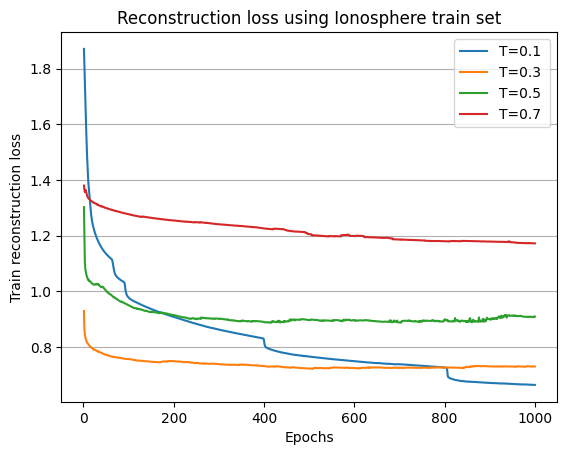

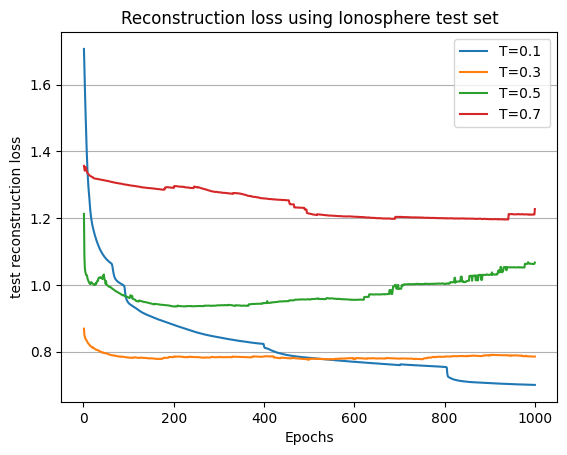

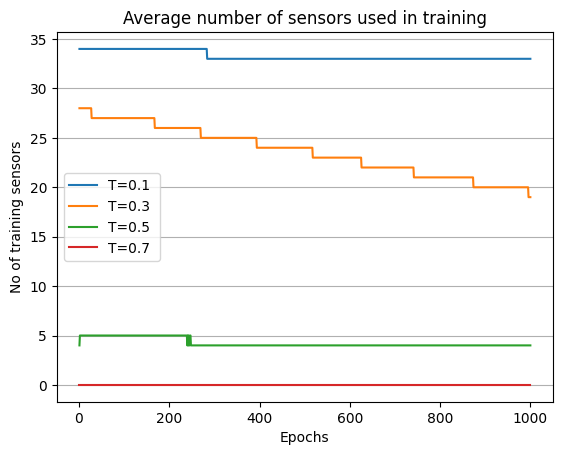

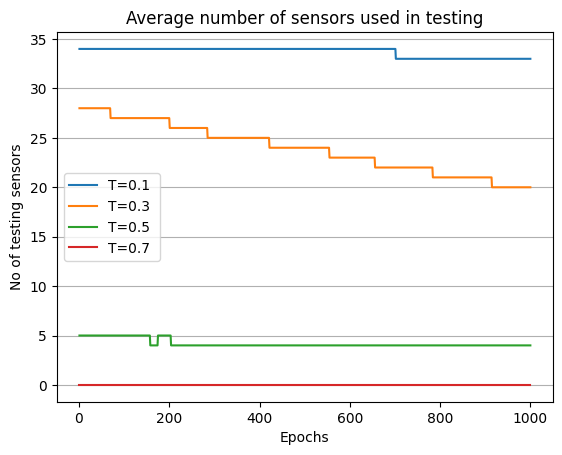

In [43]:
epochs=1000
epochS= range(1,epochs+1)
plt.plot(epochS,loss_train_arr_a, label='T=0.1')
plt.plot(epochS,loss_train_arr_b, label='T=0.3')
plt.plot(epochS,loss_train_arr_c, label='T=0.5')
plt.plot(epochS,loss_train_arr_d, label='T=0.7 ')
#plt.plot(epochS,loss_test_arr, label='T=0.5')
plt.title('Reconstruction loss using Ionosphere train set')
plt.xlabel('Epochs')
plt.ylabel('Train reconstruction loss')
plt.xticks(range(0, 1200, 200))
plt.legend(loc='best')
plt.grid(axis = 'y')
plt.show()

plt.plot(epochS,loss_test_arr_a, label='T=0.1')
plt.plot(epochS,loss_test_arr_b, label='T=0.3')
plt.plot(epochS,loss_test_arr_c, label='T=0.5')
plt.plot(epochS,loss_test_arr_d, label='T=0.7 ')
#plt.plot(epochS,loss_test_arr, label='T=0.5')
plt.title('Reconstruction loss using Ionosphere test set')
plt.xlabel('Epochs')
plt.ylabel('test reconstruction loss')
plt.xticks(range(0, 1200, 200))
plt.legend(loc='best')
plt.grid(axis = 'y')
plt.show()

#for showing avg no of sensors used in training
plt.plot(epochS,sensors_train_a, label='T=0.1')
plt.plot(epochS,sensors_train_b, label='T=0.3')
plt.plot(epochS,sensors_train_c, label='T=0.5')
plt.plot(epochS,sensors_train_d, label='T=0.7 ')
#plt.plot(epochS,loss_test_arr, label='T=0.5')
plt.title('Average number of sensors used in training')
plt.xlabel('Epochs')
plt.ylabel('No of training sensors')
plt.xticks(range(0, 1200, 200))
plt.legend(loc='best')
plt.grid(axis = 'y')
plt.show()

#for showing avg no of sensors used in testing
plt.plot(epochS,sensors_test_a, label='T=0.1')
plt.plot(epochS,sensors_test_b, label='T=0.3')
plt.plot(epochS,sensors_test_c, label='T=0.5')
plt.plot(epochS,sensors_test_d, label='T=0.7 ')
#plt.plot(epochS,loss_test_arr, label='T=0.5')
plt.title('Average number of sensors used in testing')
plt.xlabel('Epochs')
plt.ylabel('No of testing sensors')
plt.xticks(range(0, 1200, 200))
plt.legend(loc='best')
plt.grid(axis = 'y')
plt.show()